<a href="https://colab.research.google.com/github/288756/VisArtificial/blob/master/Miniproyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
import tensorflow as tf
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Montar el Google Drive en el directorio del proyecto y descomprimir el fichero con los datos
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/vision-artificial.zip' >> /dev/null  # ACTUALIZAR: ruta al fichero comprimido


Mounted at /content/gdrive


In [1]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.5 MB/s eta 0:00:00


In [9]:
# Especificar las rutas al directorio con las imágenes y al fichero con las etiquetas
imgtrain_dir = "/content/train/images/"
imgtrainmask_dir = "/content/train/masks/"
csvtrain_file = "/content/train.csv"

imgtest_dir = "/content/train.csv"
csvtest_file = "/content/test.csv"
# Leer el fichero CSV con las etiquetas
df = pd.read_csv(csvtrain_file, dtype={"class": "category"})
dftest = pd.read_csv(csvtest_file, dtype={"class": "category"})

# Codificar las etiquetas utilizando LabelEncoder
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])


In [10]:
# Dividir el conjunto en entrenamiento, validación y test (80:10:10)
val_size = int(len(df) * 0.2)
test_size = int(len(df) * 0.2)

df = df.sample(frac=1).reset_index(drop=True)  # barajar el dataframe
dftest = df[:test_size]
dfval = df[test_size:test_size+val_size]
dftrain = df[test_size+val_size:]

print(f'Número de ejemplos del conjunto de entrenamiento: {dftrain.shape[0]}')
print(f'Número de ejemplos del conjunto de validación: {dfval.shape[0]}')
print(f'Número de ejemplos del conjunto de test: {dftest.shape[0]}')
dftrain = dftrain.reset_index(drop=True)
dfval = dfval.reset_index(drop=True)
dftest = dftest.reset_index(drop=True)

Número de ejemplos del conjunto de entrenamiento: 203
Número de ejemplos del conjunto de validación: 67
Número de ejemplos del conjunto de test: 67


In [11]:
dftrain

,image_filename,mask_filename,class
0,image_033.png,mask_033.png,1
1,image_278.png,mask_278.png,0
2,image_011.png,mask_011.png,2
3,image_258.png,mask_258.png,0
4,image_212.png,mask_212.png,0
...,...,...,...
198,image_346.png,mask_346.png,1
199,image_211.png,mask_211.png,1
200,image_393.png,mask_393.png,0
201,image_349.png,mask_349.png,1


In [ ]:
archivos = os.listdir(imgtrain_dir)
anchuras = []
alturas = []
for archivo in archivos:
      imagen = Image.open(os.path.join(imgtrain_dir, archivo))
      ancho, alto = imagen.size
      anchuras.append(ancho)
      alturas.append(alto)
media_anchura = sum(anchuras) / len(anchuras)
media_altura = sum(alturas) / len(alturas)

print("Media de anchura:", media_anchura)
print("Media de altura:", media_altura)

Media de anchura: 634.9139465875371
Media de altura: 514.9317507418398


In [14]:
# Dimensiones deseadas de la imagen
img_width, img_height = 448,448
n_channels = 3                # número de canales (RGB)
n_classes = 3                 # número de clases

def load_and_preprocess_image(image_filename, mask_filename, label):
    image_path = tf.strings.join([imgtrain_dir, image_filename])
    mask_path = tf.strings.join([imgtrainmask_dir, mask_filename])

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=n_channels)
    image = tf.image.resize(image, [img_width, img_height])
    image = image / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Decodificar como imagen PNG de un solo canal (escala de grises)
    mask = tf.image.resize(mask, [img_width, img_height])
    mask = mask * tf.cast(label, tf.float32)

    return image, mask


# Crear conjunto de datos
def get_dataset(df):
    image_paths = df['image_filename'].values
    mask_paths = df['mask_filename'].values
    labels = df['class'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths, labels))
    dataset = dataset.map(load_and_preprocess_image)

    return dataset


# Crear los conjuntos de datos y preparar los lotes
batch_size = 32
train_dataset = get_dataset(dftrain).batch(batch_size)
val_dataset = get_dataset(dfval).batch(batch_size)
test_dataset = get_dataset(dftest).batch(batch_size)

print(f'Número de lotes del conjunto de entrenamiento: {len(train_dataset)}')
print(f'Número de lotes del conjunto de validación: {len(val_dataset)}')
print(f'Número de lotes del conjunto de test: {len(test_dataset)}')

Número de lotes del conjunto de entrenamiento: 7
Número de lotes del conjunto de validación: 3
Número de lotes del conjunto de test: 3


Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


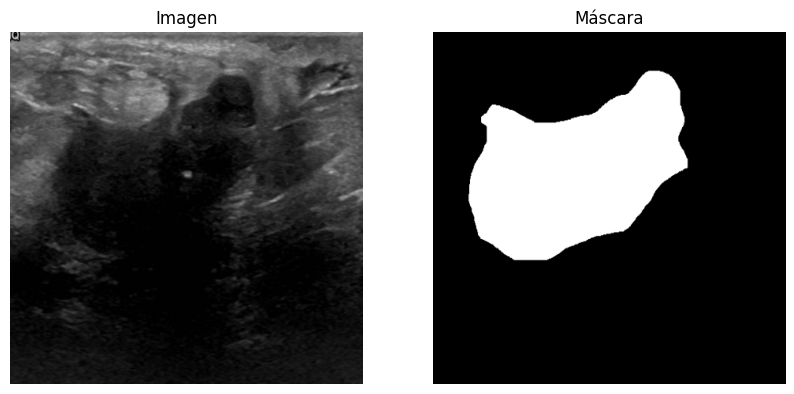

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


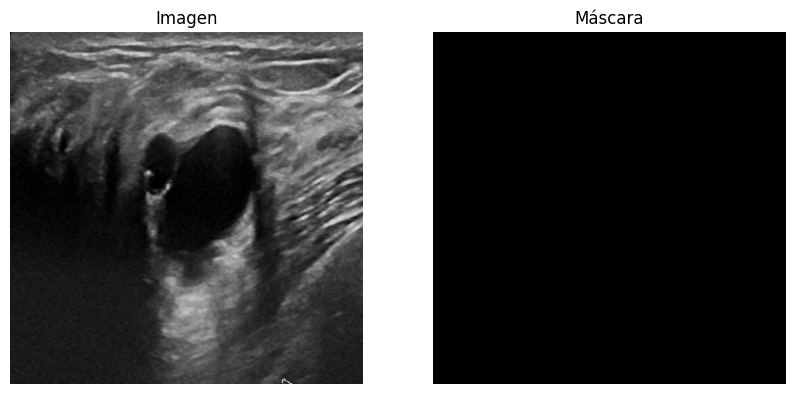

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


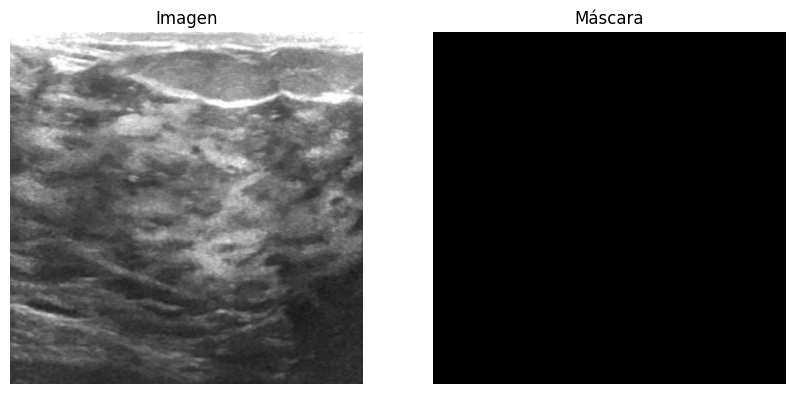

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


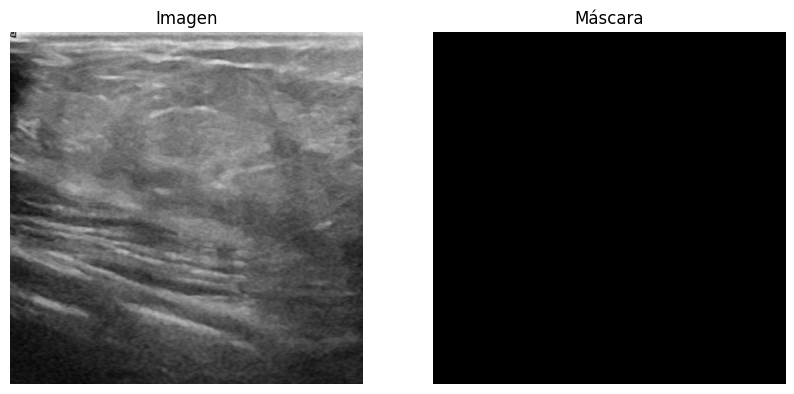

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


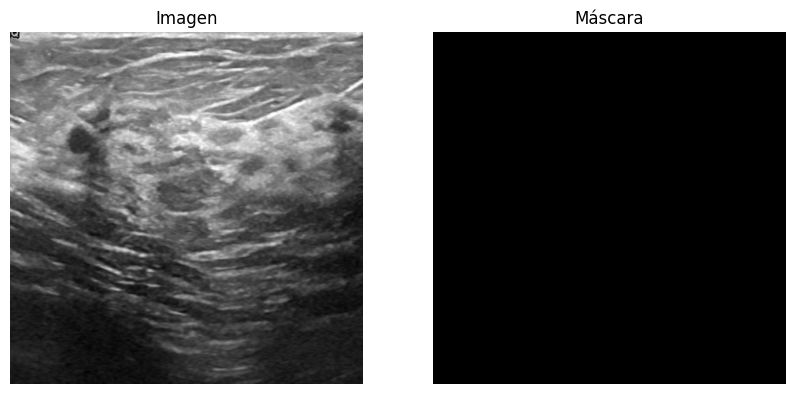

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


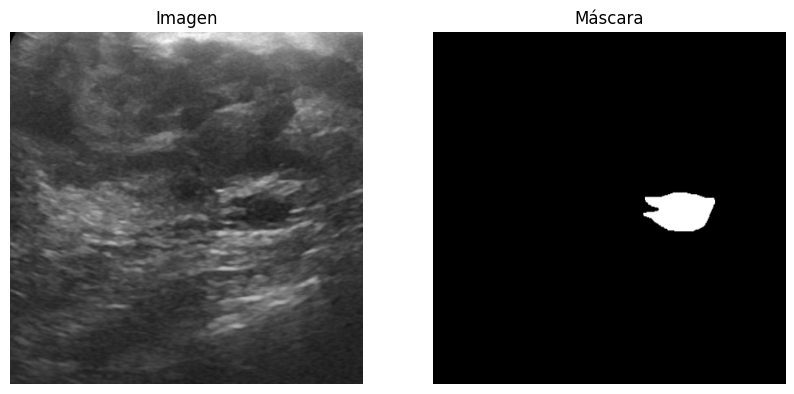

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


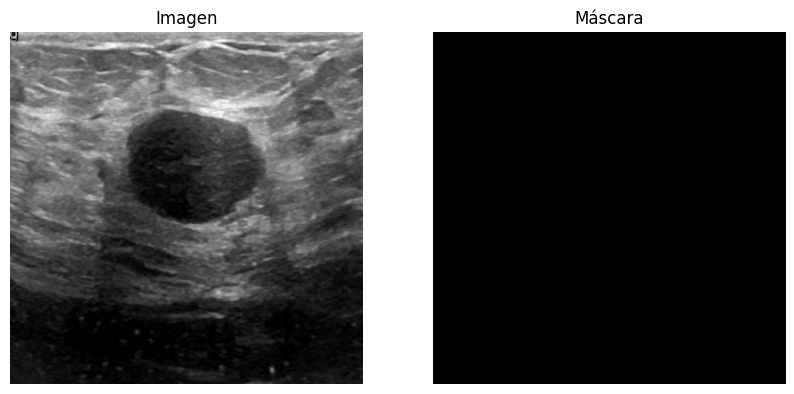

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


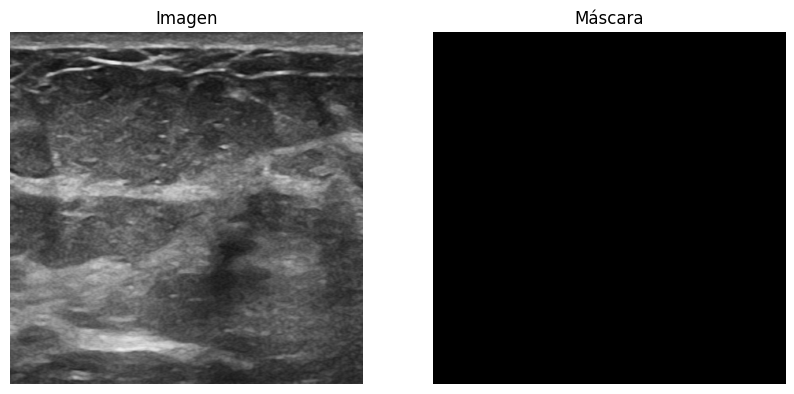

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


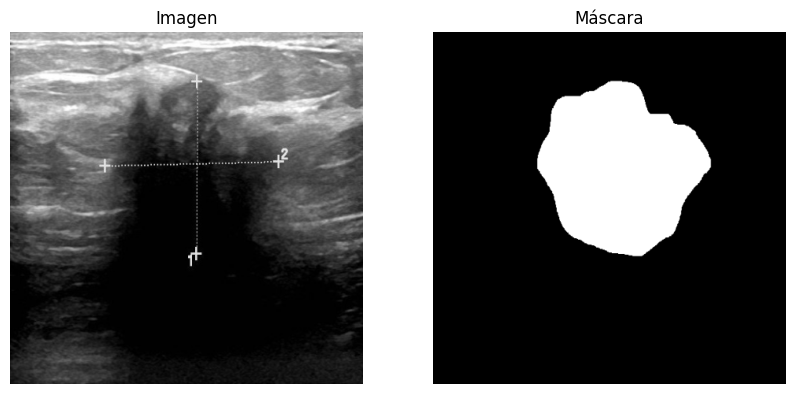

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


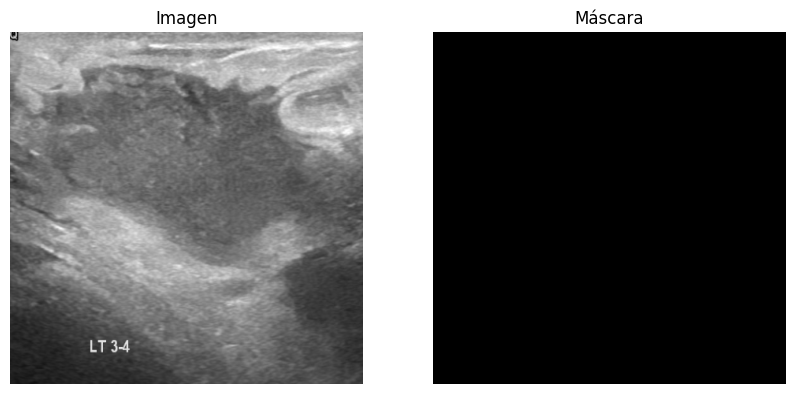

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


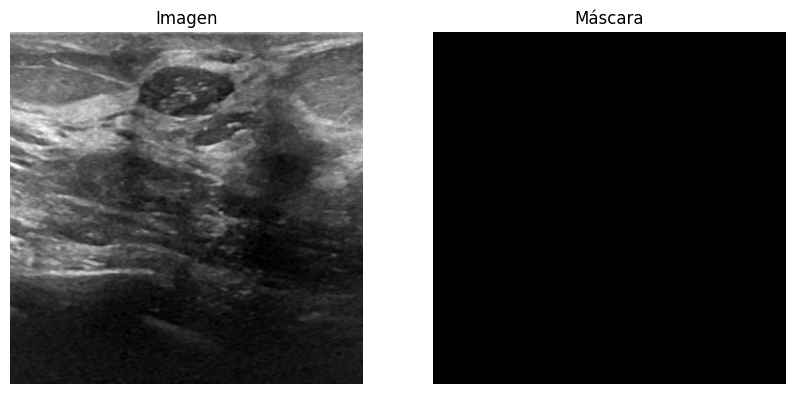

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


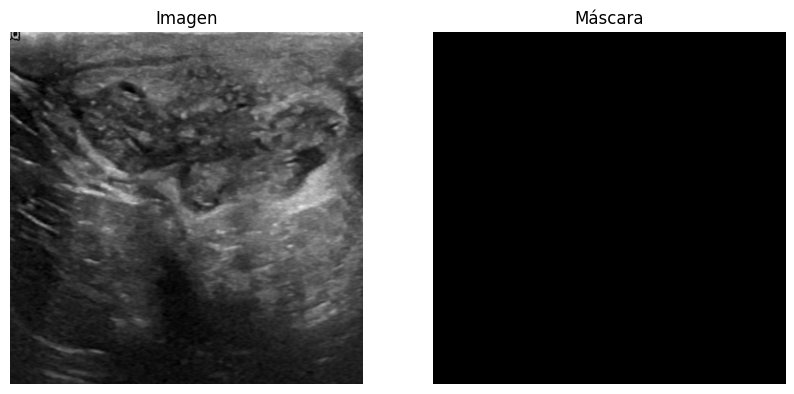

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


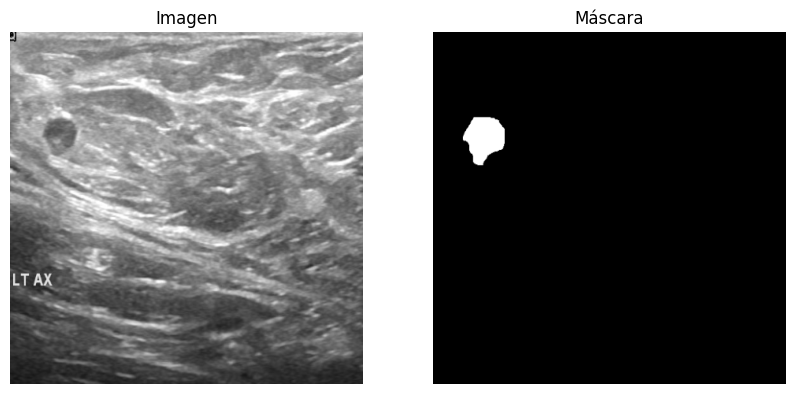

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


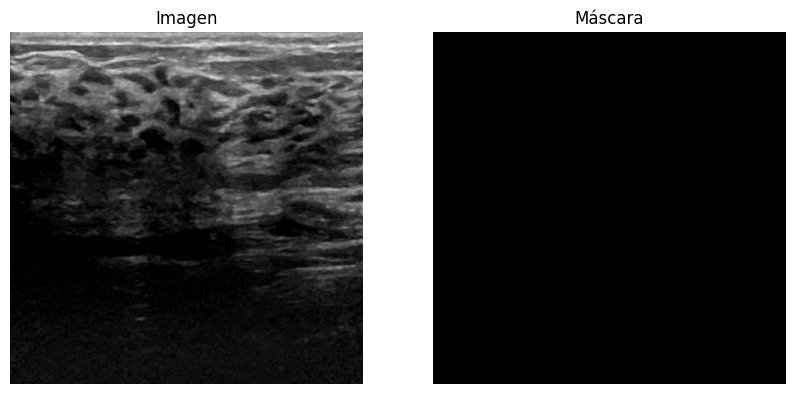

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


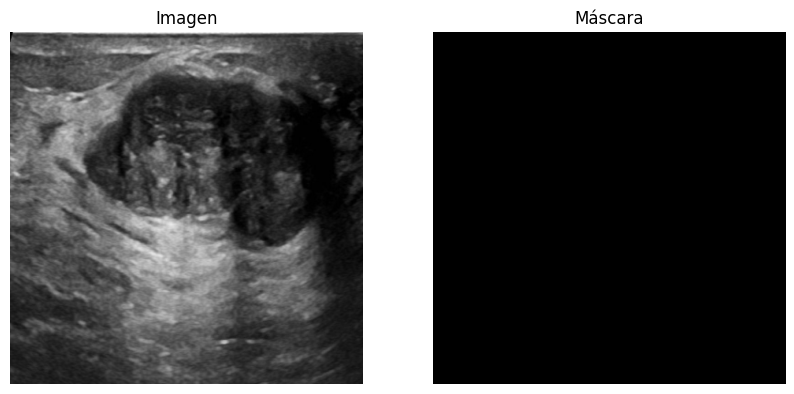

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


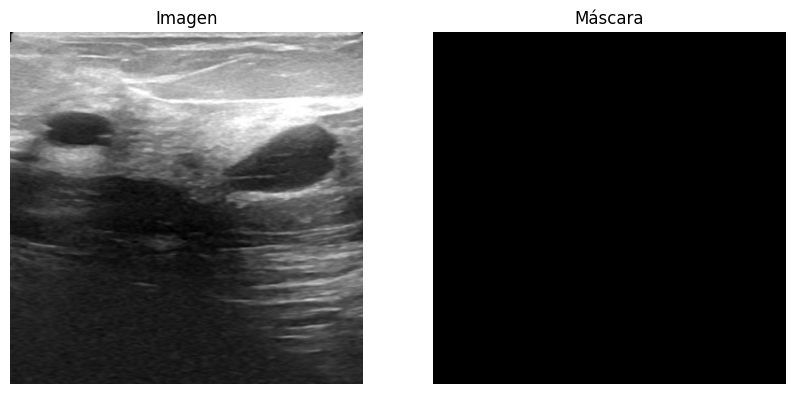

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


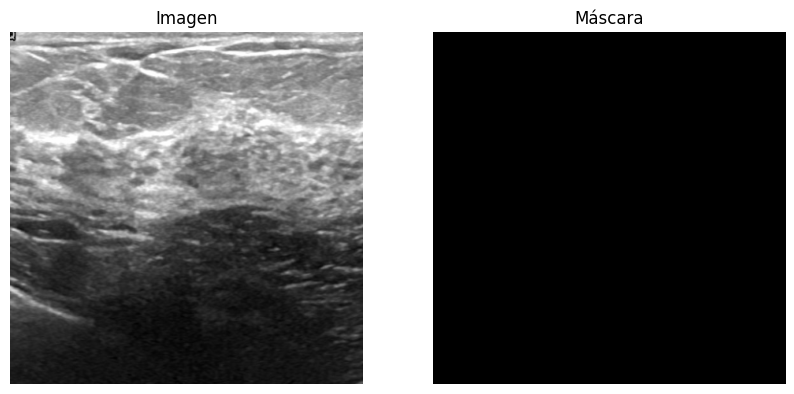

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


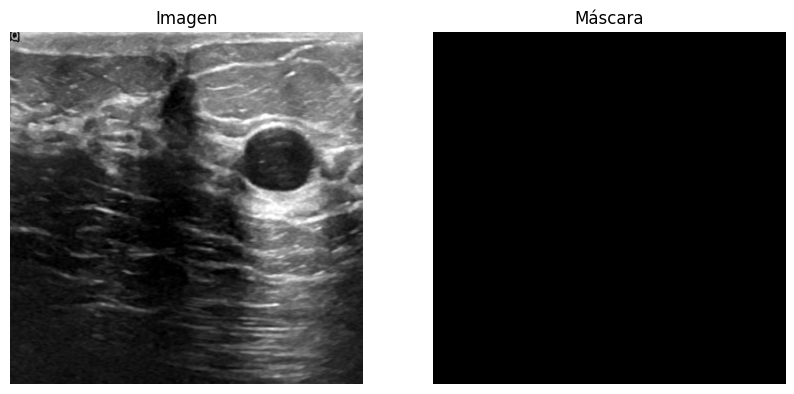

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


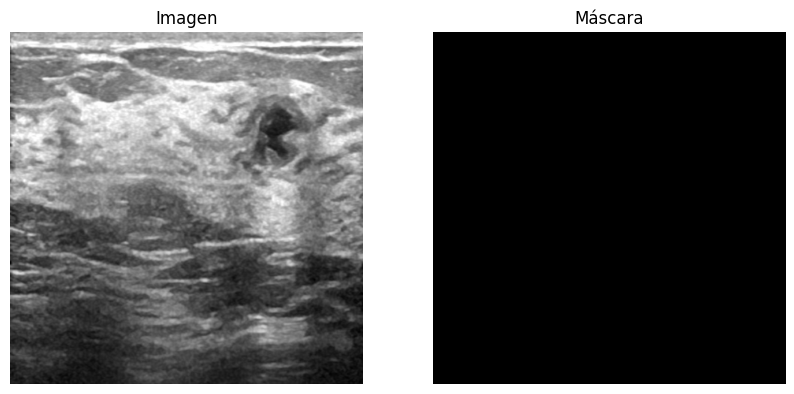

In [15]:
# Imprimir algunos ejemplos del conjunto de entrenamiento
num_examples_to_print = 19
for batch_image, batch_mask in train_dataset.take(1):  # Solo tomamos el primer lote
    for i in range(num_examples_to_print):
        # Extraer una imagen y su máscara del lote
        image = batch_image[i]
        mask = batch_mask[i]

        # Imprimir el tamaño de la imagen y la máscara
        print(f"Tamaño de la imagen: {image.shape}, Tamaño de la máscara: {mask.shape}")

        # Mostrar la imagen y la máscara utilizando matplotlib
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image.numpy())
        plt.title('Imagen')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask.numpy().squeeze(), cmap='gray')  # Squeeze para eliminar la dimensión de canal
        plt.title('Máscara')
        plt.axis('off')

        plt.show()


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import backend as K
from keras.applications import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

def build_model(num_classes):
    # Cargar el modelo preentrenado InceptionV3 sin las capas fully-connected
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # Congelar todas las capas del modelo preentrenado
    for layer in base_model.layers:
        layer.trainable = False

    # Agregar capas personalizadas al final del modelo
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Usar sigmoid para salida binaria

    # Definir el nuevo modelo
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    # Compute the weighted F1 score
    weights = K.sum(y_true, axis=0) / K.sum(y_true)
    weighted_f1 = K.sum(weights * f1)

    return weighted_f1


# Definir el tamaño de entrada y el número de clases
input_shape = (448, 448, 3)
num_classes = 1  # Solo necesitas una salida para la máscara binaria

model = build_model(num_classes)

model.compile(loss='binary_crossentropy',  # Cambiar a binary_crossentropy
              optimizer="adam",
              metrics=[f1_metric])

# Imprimir el resumen del modelo
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, None, None, 32)       96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, None, None, 32)       0         ['batch_normalization_94

In [19]:
early_stopping = EarlyStopping(monitor='val_f1_metric', patience=20, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_f1_metric', factor=0.2, patience=5, min_lr=0.00001)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    verbose = 2,
    steps_per_epoch=np.ceil(len(dftrain) / batch_size),
    validation_steps=np.ceil(len(dfval) / batch_size),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 1) vs (None, 448, 448, 1)).


In [ ]:
test_loss, test_medida = model.evaluate(test_dataset, verbose=2)
print("test_loss: %.4f, test_medida: %.4f" % (test_loss, test_medida))

3/3 - 0s - loss: 0.6312 - f1_metric: 0.7575 - 373ms/epoch - 124ms/step
test_loss: 0.6312, test_medida: 0.7575


In [ ]:
# Directorio donde se encuentran las imágenes de prueba
test_images_dir = 'test/images/'

# Obtener la lista de nombres de archivos de las imágenes de prueba
test_filenames = os.listdir(test_images_dir)

# Crear un DataFrame para almacenar las predicciones
predictions_df = pd.DataFrame({'image_filename': test_filenames})

# Crear columnas para 'normal', 'benign' y 'malignant' con valores iniciales de 0
predictions_df['normal'] = 0
predictions_df['benign'] = 0
predictions_df['malignant'] = 0

# Iterar sobre cada imagen de prueba
for filename in test_filenames:
    # Cargar la imagen y preprocesarla
    img_path = os.path.join(test_images_dir, filename)
    img = load_img(img_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión adicional para el lote

    # Realizar la predicción
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Obtener la clase predicha

    # Actualizar las columnas correspondientes según la predicción
    if predicted_class == 0:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'normal'] = 1
    elif predicted_class == 1:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'benign'] = 1
    elif predicted_class == 2:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'malignant'] = 1

# Ordenar el DataFrame por el nombre del archivo de imagen
predictions_df = predictions_df.sort_values(by='image_filename')

# Guardar el DataFrame en un archivo CSV
predictions_df.to_csv('test_predictions.csv', index=False)

# Imprimir las primeras filas del DataFrame para verificar
print(predictions_df.head())


1/1 [==============================] - 0s 29ms/step
    image_filename  normal  benign  malignant
64   image_005.png       0       1          0
53   image_006.png       0       1          0
112  image_007.png       0       1          0
40   image_009.png       0       1          0
21   image_010.png       0       1          0
